In [84]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os

# font = {'family': 'Tahoma'}
font = {'family': 'Times New Roman'}
plt.rc('font', **font)

colors_fill = [None, "#54637C", "#587C86", "#5D928B","#65A68D", "#71B88E", "#83C98F", "#9CD790", "#BBE394", "#D9ED9D", "#F1F4B0", "#FEFAD3"]

In [85]:
num_total_cores = 8 + 1
model="densenet201"
base_path = f"../data/data-1115/gpu-accel/{model}/"

# 데이터를 수집할 데이터프레임을 초기화
columns = ['glayer', 'throughput', 'frame_rate', 'execution_time', 'cycle_time', 'num_thread_data', 'num_thread', 'accel_gain', 'block_loss', 'max_delay', 'min_delay']
data_list = []

# Loop through thread counts from 0 to 11
for num_thread in range(1, num_total_cores):  # including 11
    path = f"{base_path}{num_thread}thread/"
    
    # Check if directory exists
    if os.path.exists(path):
        # Read data from files
        for filename in sorted(os.listdir(path)):
            if filename.endswith(".csv"):
                num_glayer = int(filename.split('_')[2].replace('.csv', ''))
                df = pd.read_csv(os.path.join(path, filename))
                task_num = len(df)
                start_preprocess_time = df["start_preprocess"].iloc[0]
                end_infer_time = df["end_postprocess"].iloc[-1]
                Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
                if(num_glayer == 0):
                    infer_time_standard = df["e_infer"].mean() - df["waiting_gpu"].mean()
                acceleration_gain = infer_time_standard - (df["e_infer"].mean() - df["waiting_gpu"].mean())

                block_loss = df["waiting_gpu"].mean()
                max_delay = df["execution_time"].max()
                min_delay = df["execution_time"].min()
                avg_frame_rate = df["frame_rate"].mean()
                avg_execution_time = df["execution_time"].mean()
                avg_cycle_time = df["cycle_time"].mean()
                avg_num_thread_data = df["num_thread"].mean()
                
                # 데이터프레임에 데이터 추가
                data_list.append([num_glayer, Throughput, avg_frame_rate, avg_execution_time, avg_cycle_time, avg_num_thread_data, num_thread, acceleration_gain, block_loss, max_delay, min_delay])
print(df["execution_time"].idxmax())
# 데이터프레임 생성
data_df = pd.DataFrame(data_list, columns=columns)
data_df = data_df.pivot(index='glayer', columns='num_thread')

frame_rate_df = data_df['frame_rate']
execution_time_df = data_df['execution_time']
cycle_time_df = data_df['cycle_time']

# 파일 경로 설정
frame_rate_file_path = './gpu-accel-GC_frame_rate_data.csv'
execution_time_file_path = './gpu-accel-GC_execution_time_data.csv'
cycle_time_file_path = './gpu-accel-GC_cycle_time_data.csv'

# 파일 저장
frame_rate_df.to_csv(frame_rate_file_path)
execution_time_df.to_csv(execution_time_file_path)
cycle_time_df.to_csv(cycle_time_file_path)

print(frame_rate_file_path, execution_time_file_path, cycle_time_file_path)

90
./gpu-accel-GC_frame_rate_data.csv ./gpu-accel-GC_execution_time_data.csv ./gpu-accel-GC_cycle_time_data.csv


In [86]:
# 결과를 저장할 리스트 초기화
max_values = []

# 각 스레드 수에 대해 반복
for num_thread in range(1, num_total_cores):
    if num_thread in data_df['frame_rate'].columns:
        # frame_rate의 최대값 찾기
        max_throughput = data_df['throughput'][num_thread].max()
        # 최대 frame_rate의 인덱스 찾기
        max_index = data_df['throughput'][num_thread].idxmax()
        # 해당 인덱스의 execution_time 가져오기
        corresponding_execution_time = data_df['execution_time'][num_thread].loc[max_index]

        # 결과 저장
        max_values.append({
            'num_thread': num_thread,
            'glayer': max_index,
            'max_throughput': max_throughput,
            'execution_time_at_max_fr': corresponding_execution_time
        })

# 결과 출력
print("Point for Max Frame rate")
for result in max_values:
    print(f"Threads: {result['num_thread']}, Glayers: {result['glayer']}, Max Throughput: {result['max_throughput']:.2f}, Execution Time: {result['execution_time_at_max_fr']:.2f}")

Point for Max Frame rate
Threads: 1, Glayers: 304, Max Throughput: 34.78, Execution Time: 28.75
Threads: 2, Glayers: 301, Max Throughput: 54.02, Execution Time: 36.01
Threads: 3, Glayers: 264, Max Throughput: 57.24, Execution Time: 50.61
Threads: 4, Glayers: 227, Max Throughput: 61.16, Execution Time: 62.82
Threads: 5, Glayers: 205, Max Throughput: 63.15, Execution Time: 75.79
Threads: 6, Glayers: 202, Max Throughput: 64.70, Execution Time: 88.62
Threads: 7, Glayers: 196, Max Throughput: 65.70, Execution Time: 101.68
Threads: 8, Glayers: 190, Max Throughput: 66.78, Execution Time: 114.20


In [87]:
# 결과를 저장할 리스트 초기화
cross_points = []

# 각 스레드 수와 그 다음 스레드 수 비교
for num_thread in range(10, num_total_cores - 1):
    current_thread_frame_rates = data_df['frame_rate'][num_thread]
    next_thread_frame_rates = data_df['frame_rate'][num_thread + 1]
    current_thread_execution_time = data_df['execution_time'][num_thread]
    next_thread_execution_time = data_df['execution_time'][num_thread + 1]
    
    # glayer를 순회하면서 현재 스레드의 frame_rate가 다음 스레드의 frame_rate를 넘는 첫 번째 지점 찾기
    for glayer in current_thread_frame_rates.index:
        if current_thread_frame_rates[glayer] >= next_thread_frame_rates[glayer]:
            cross_points.append({
                'num_thread': num_thread,
                'glayer': glayer,
                'current_frame_rate': current_thread_frame_rates[glayer],
                'next_frame_rate': next_thread_frame_rates[glayer],
                'current_execution_time': current_thread_execution_time[glayer],
                'next_execution_time': next_thread_execution_time[glayer]
            })
            break  # 첫 번째 조건 충족 지점에서 루프 종료

# 결과 출력
for point in cross_points:
    print(f"Thread {point['num_thread']} exceeds Thread {point['num_thread']+1} at Glayer {point['glayer']}:")
    print(f"  Thread {point['num_thread']}: {point['current_frame_rate']:.2f} fps, Thread {point['num_thread']+1}: {point['next_frame_rate']:.2f} fps")
    print(f"  Thread {point['num_thread']}: {point['current_execution_time']:.2f} ms, Thread {point['num_thread']+1}: {point['next_execution_time']:.2f} ms")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


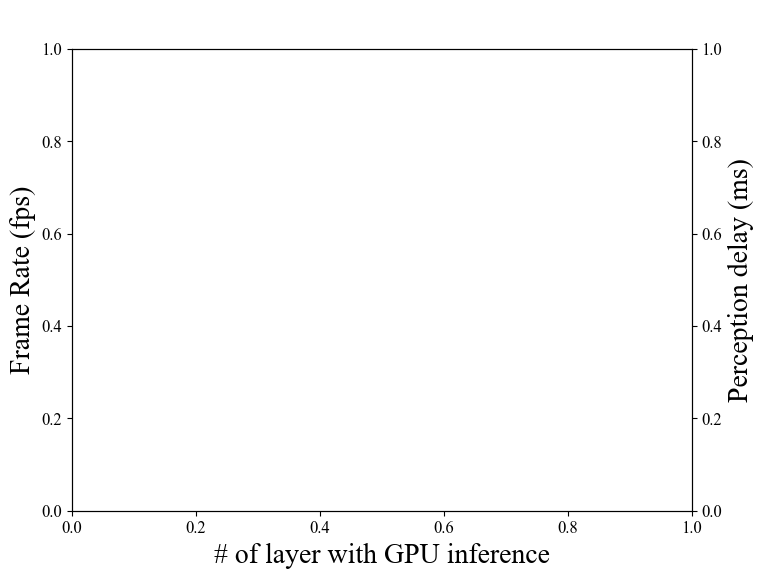

In [88]:
# Set up the plot
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
ax3 = ax1.twinx()

colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택

# 각 스레드에 대한 데이터 플롯
for num_thread in range(10, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = -num_thread)
        ax3.plot(data_df.index, data_df[('execution_time', num_thread)], label=f"{num_thread} threads", color=color, zorder = -num_thread)
        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = -num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=-num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = -num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=-num_thread)


ax1.set_xlabel('# of layer with GPU inference', size=20)
ax1.set_ylabel("Frame Rate (fps)", size=20)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

ax3.set_ylabel("Perception delay (ms)", size=20)
ax2.set_xlabel('# of layer with GPU inference', size=20)
ax2.set_ylabel('Minimum # of thread', size=20)

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
ax3.tick_params(axis='both', labelsize=12)
# ax3.legend(loc='upper left')

#plt.tight_layout()
plt.show()


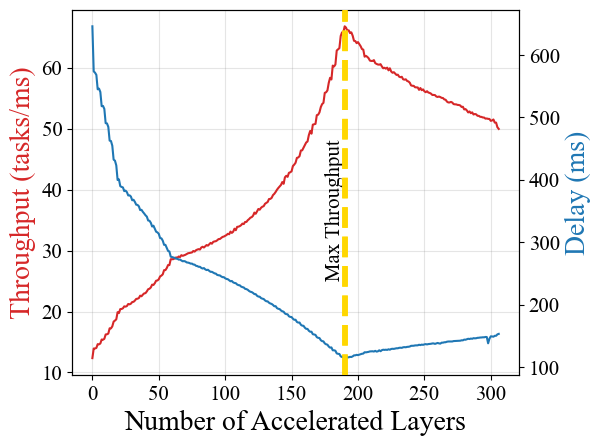

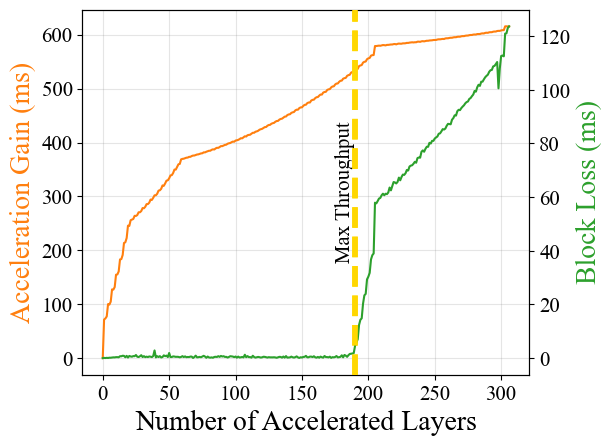

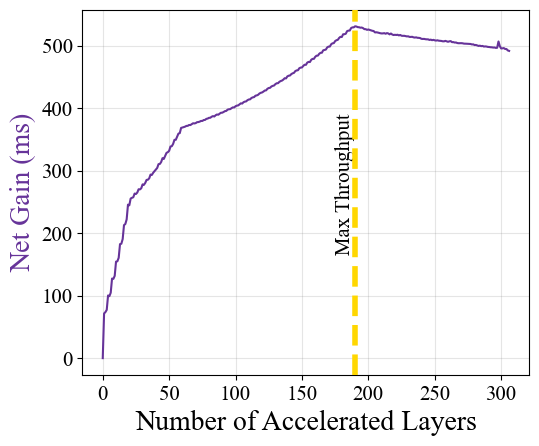

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [89]:
# Set up the plot
fig1, ax1 = plt.subplots(figsize=(6, 5))
fig3, ax3 = plt.subplots(figsize=(6, 5))
fig5, ax5 = plt.subplots(figsize=(6, 5))
ax2=ax1.twinx()
ax4=ax3.twinx()
colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(8, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        #plt.subplots_adjust(bottom=0.1, right=0.7)    
        #ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax1.plot(data_df.index, data_df[('throughput', num_thread)], label=f"{num_thread} threads", color="tab:red", zorder = num_thread)
        ax2.plot(data_df.index, data_df[('execution_time', num_thread)], color="tab:blue", zorder = num_thread)
        #plt.subplots_adjust(bottom=0.1, right=0.7)    
        ax3.plot(data_df.index, data_df[('accel_gain', num_thread)], color="tab:orange", zorder = num_thread)
        ax4.plot(data_df.index, data_df[('block_loss', num_thread)], color="tab:green", zorder = num_thread)
        #plt.subplots_adjust(bottom=0.1, right=0.9)
        ax5.plot(data_df.index, data_df[('accel_gain', 8)] - data_df[('block_loss', 8)], color="rebeccapurple", zorder = num_thread)
        ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        ax2.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        ax3.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        ax4.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)
        ax5.axvline(x=max_values[num_thread - 1]['glayer'], color='gold', zorder = num_thread, linestyle='--', alpha=1, linewidth=4)

        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)
        ax1.text(max_values[num_thread - 1]['glayer'], data_df[('throughput', num_thread)].mean()-6, "Max Throughput", color="black", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=15)
        ax3.text(max_values[num_thread - 1]['glayer'], data_df[('accel_gain', num_thread)].mean()-150, "Max Throughput", color="black", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=15)
        ax5.text(max_values[num_thread - 1]['glayer'], (data_df[('accel_gain', 8)] - data_df[('block_loss', 8)]).mean()-150, "Max Throughput", color="black", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=15)

# ax1.set_xlabel('# of layer with GPU inference', size=20)
# ax1.set_ylabel("Frame Rate (fps)", size=20)
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)

ax1.set_ylabel("Throughput (tasks/ms)", size=20, color="tab:red")
ax2.set_ylabel("Delay (ms)", size = 20, color="tab:blue")
ax3.set_ylabel("Acceleration Gain (ms)", size=20, color="tab:orange")
ax4.set_ylabel("Block Loss (ms)", size = 20, color="tab:green")
ax5.set_ylabel("Net Gain (ms)", size = 20, color="rebeccapurple")

ax1.set_xlabel('Number of Accelerated Layers', size=20)
ax3.set_xlabel('Number of Accelerated Layers', size=20)
ax5.set_xlabel('Number of Accelerated Layers', size=20)

# ax2.set_ylabel('Minimum # of thread', size=20)

ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', labelsize=15)
ax4.tick_params(axis='both', labelsize=15)
ax5.tick_params(axis='both', labelsize=15)
#ax1.legend(loc='lower center', bbox_to_anchor=(-0.3, 0.1), fontsize=6)
#ax3.legend(loc='upper left', fontsize=3)
#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8)
#plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.4)

ax1.grid(color='gray', alpha=0.2)
ax3.grid(color='gray', alpha=0.2)
ax5.grid(color='gray', alpha=0.2)
fig1.subplots_adjust(bottom=0.15, right=0.87)
fig3.subplots_adjust(bottom=0.15, right=0.87)
fig5.subplots_adjust(bottom=0.15, right=0.87)


plt.show()
#plt.tight_layout()
output_path = f'./output/1118/Throughput_Delay_{model}.eps'
fig1.savefig(output_path, format='eps', dpi=300)
output_path = f'./output/1118/AccelGain_BlockLoss_{model}.eps'
fig3.savefig(output_path, format='eps', dpi=300)
output_path = f'./output/1118/Netgain_{model}.eps'
fig5.savefig(output_path, format='eps', dpi=300)

output_path = f'./output/1118/Throughput_Delay_{model}.png'
fig1.savefig(output_path, format='png', dpi=300)
output_path = f'./output/1118/AccelGain_BlockLoss_{model}.png'
fig3.savefig(output_path, format='png', dpi=300)
output_path = f'./output/1118/Netgain_{model}.png'
fig5.savefig(output_path, format='png', dpi=300)

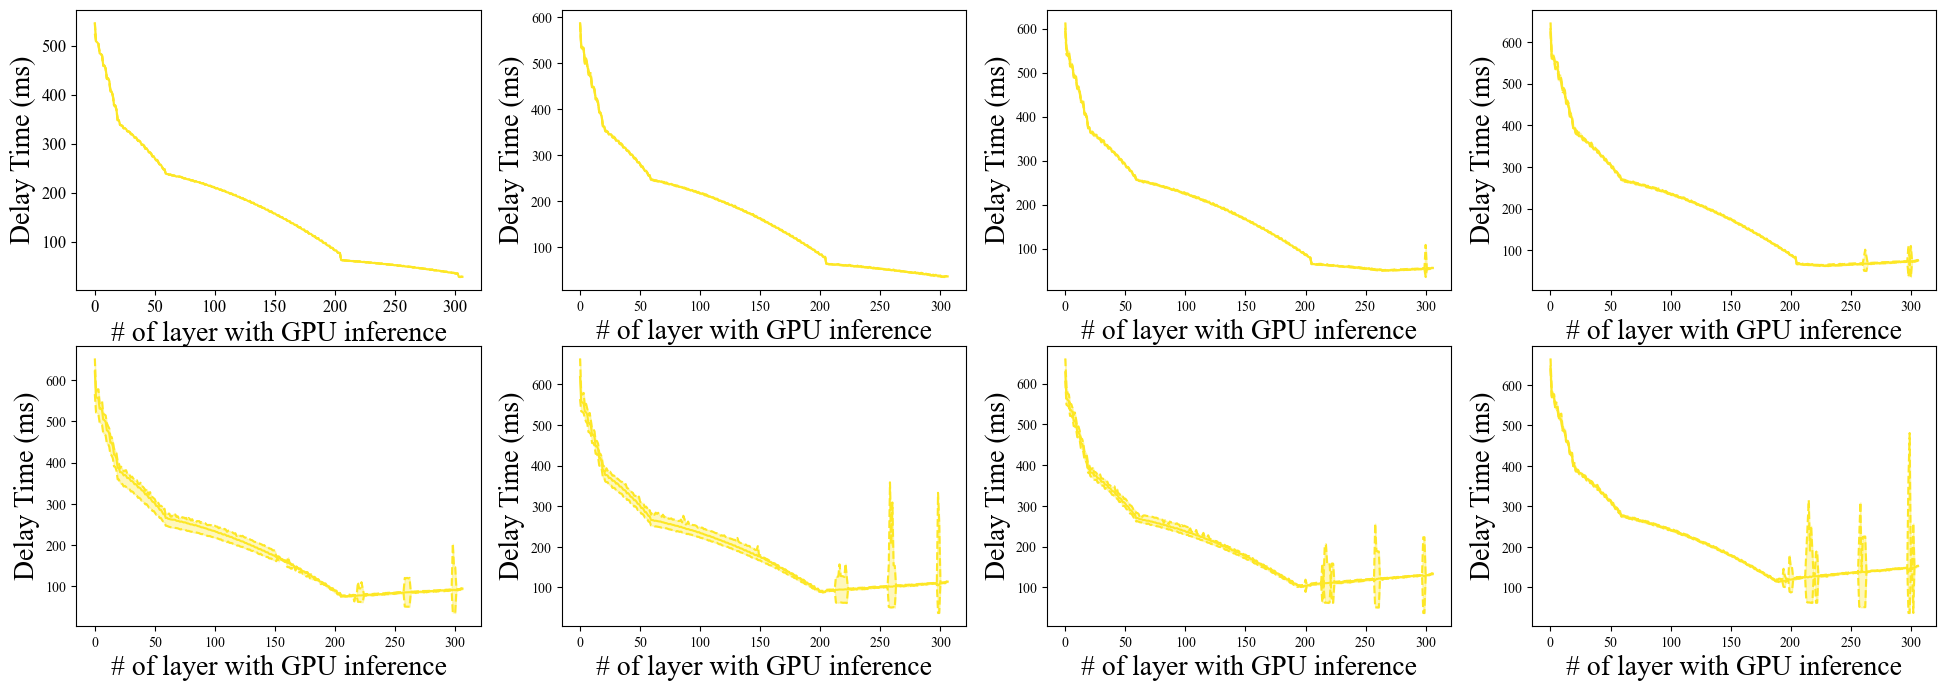

In [90]:

# Set up the plot
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8] ) = plt.subplots(2, 4, figsize=(24, 8))
colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(1, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]

ax1.plot(data_df.index, data_df[('execution_time', 1)], color=color, zorder = 1)
ax1.plot(data_df.index, data_df[('max_delay', 1)], color=color, zorder = 1, linestyle='--')
ax1.plot(data_df.index, data_df[('min_delay', 1)], color=color, zorder = 1, linestyle='--')
ax1.fill_between(data_df.index, data_df[('max_delay', 1)], data_df[('min_delay', 1)], color=color, alpha=0.3)
       
ax2.plot(data_df.index, data_df[('execution_time', 2)], color=color, zorder = 2)
ax2.plot(data_df.index, data_df[('max_delay', 2)], color=color, zorder = 2, linestyle='--')
ax2.plot(data_df.index, data_df[('min_delay', 2)], color=color, zorder = 2, linestyle='--')
ax2.fill_between(data_df.index, data_df[('max_delay', 2)], data_df[('min_delay', 2)], color=color, alpha=0.3)
       
ax3.plot(data_df.index, data_df[('execution_time', 3)], color=color, zorder = 3)
ax3.plot(data_df.index, data_df[('max_delay', 3)], color=color, zorder = 3, linestyle='--')
ax3.plot(data_df.index, data_df[('min_delay', 3)], color=color, zorder = 3, linestyle='--')
ax3.fill_between(data_df.index, data_df[('max_delay', 3)], data_df[('min_delay', 3)], color=color, alpha=0.3)     

ax4.plot(data_df.index, data_df[('execution_time', 4)], color=color, zorder = 4)
ax4.plot(data_df.index, data_df[('max_delay', 4)], color=color, zorder = 4, linestyle='--')
ax4.plot(data_df.index, data_df[('min_delay', 4)], color=color, zorder = 4, linestyle='--')
ax4.fill_between(data_df.index, data_df[('max_delay', 4)], data_df[('min_delay', 4)], color=color, alpha=0.3)  

ax5.plot(data_df.index, data_df[('execution_time', 5)], color=color, zorder = 5)
ax5.plot(data_df.index, data_df[('max_delay', 5)], color=color, zorder = 5, linestyle='--')
ax5.plot(data_df.index, data_df[('min_delay', 5)], color=color, zorder = 5, linestyle='--')
ax5.fill_between(data_df.index, data_df[('max_delay', 5)], data_df[('min_delay', 5)], color=color, alpha=0.3) 

ax6.plot(data_df.index, data_df[('execution_time', 6)], color=color, zorder = 6)
ax6.plot(data_df.index, data_df[('max_delay', 6)], color=color, zorder = 6, linestyle='--')
ax6.plot(data_df.index, data_df[('min_delay', 6)], color=color, zorder = 6, linestyle='--')
ax6.fill_between(data_df.index, data_df[('max_delay', 6)], data_df[('min_delay', 6)], color=color, alpha=0.3)   

ax7.plot(data_df.index, data_df[('execution_time', 7)], color=color, zorder = 7)
ax7.plot(data_df.index, data_df[('max_delay', 7)], color=color, zorder = 7, linestyle='--')
ax7.plot(data_df.index, data_df[('min_delay', 7)], color=color, zorder = 7, linestyle='--')
ax7.fill_between(data_df.index, data_df[('max_delay', 7)], data_df[('min_delay', 7)], color=color, alpha=0.3)   

ax8.plot(data_df.index, data_df[('execution_time', 8)], color=color, zorder = 8)
ax8.plot(data_df.index, data_df[('max_delay', 8)], color=color, zorder = 8, linestyle='--')
ax8.plot(data_df.index, data_df[('min_delay', 8)], color=color, zorder = 8, linestyle='--')
ax8.fill_between(data_df.index, data_df[('max_delay', 8)], data_df[('min_delay', 8)], color=color, alpha=0.3)

ax1.set_ylabel("Delay Time (ms)", size = 20)
ax1.set_xlabel('# of layer with GPU inference', size=20)
ax2.set_ylabel("Delay Time (ms)", size = 20)
ax2.set_xlabel('# of layer with GPU inference', size=20)
ax3.set_ylabel("Delay Time (ms)", size = 20)
ax3.set_xlabel('# of layer with GPU inference', size=20)
ax4.set_ylabel("Delay Time (ms)", size = 20)
ax4.set_xlabel('# of layer with GPU inference', size=20)
ax5.set_ylabel("Delay Time (ms)", size = 20)
ax5.set_xlabel('# of layer with GPU inference', size=20)
ax6.set_ylabel("Delay Time (ms)", size = 20)
ax6.set_xlabel('# of layer with GPU inference', size=20)
ax7.set_ylabel("Delay Time (ms)", size = 20)
ax7.set_xlabel('# of layer with GPU inference', size=20)
ax8.set_ylabel("Delay Time (ms)", size = 20)
ax8.set_xlabel('# of layer with GPU inference', size=20)
ax1.tick_params(axis='both', labelsize=12)
# ax2.tick_params(axis='both', labelsize=12)
# ax3.tick_params(axis='both', labelsize=12)
#ax1.legend(loc='lower center', bbox_to_anchor=(-0.3, 0.1), fontsize=6)
#ax3.legend(loc='upper left', fontsize=3)
#plt.tight_layout()
plt.show();

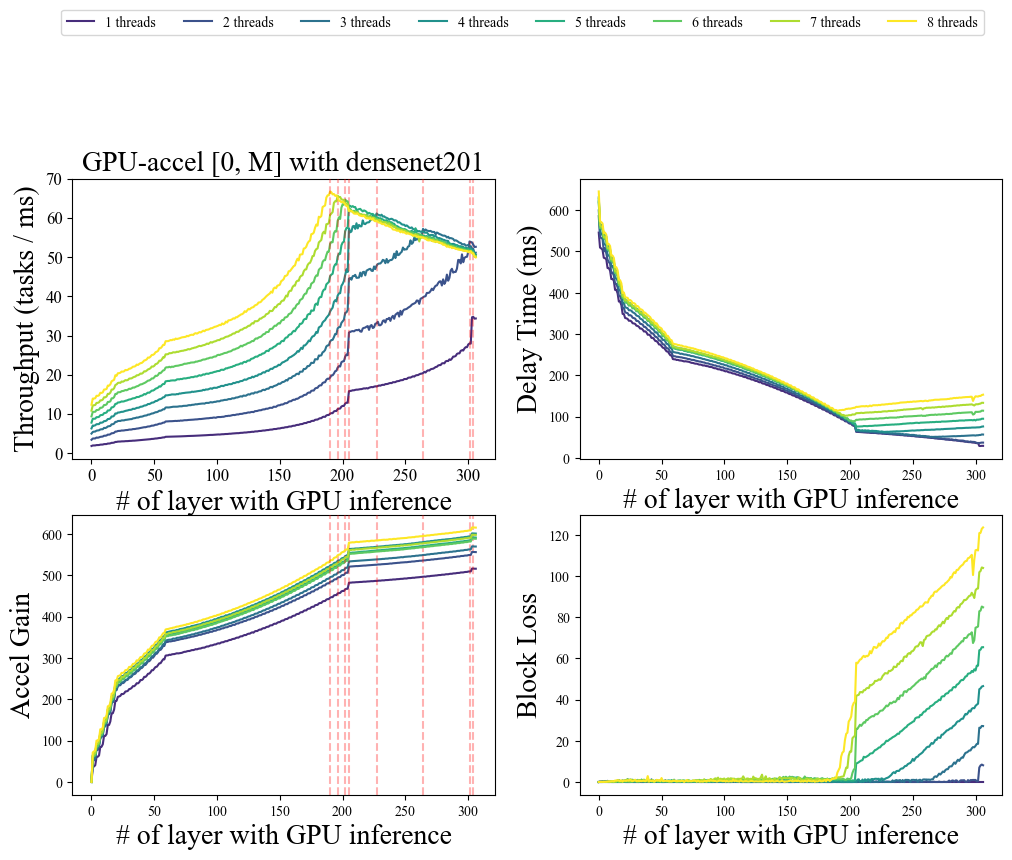

Delay at Max Throughput: 114.19927631578948
Accel Gain at Max Throughput: 535.3911184210526
Block Loss at Max Throughput: 4.580986842105263
Delay at Max last layer: 153.0303947368421
Accel Gain at last layer: 615.1278289473684
Block Loss at last layer: 123.64690789473686
Delay Gap: 38.831118421052636
Accel Gain Gap: 79.73671052631573
Block Loss Gap: 119.0659210526316


In [91]:
# Set up the plot
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(1, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        #ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax1.plot(data_df.index, data_df[('throughput', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax2.plot(data_df.index, data_df[('execution_time', num_thread)], color=color, zorder = num_thread)
        ax3.plot(data_df.index, data_df[('accel_gain', num_thread)], color=color, zorder = num_thread)
        ax4.plot(data_df.index, data_df[('block_loss', num_thread)], color=color, zorder = num_thread)
        ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)
        ax3.axvline(x=max_values[num_thread - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)

        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)


# ax1.set_xlabel('# of layer with GPU inference', size=20)
# ax1.set_ylabel("Frame Rate (fps)", size=20)
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)

ax1.set_ylabel("Throughput (tasks / ms)", size=20)
ax2.set_ylabel("Delay Time (ms)", size = 20)
ax3.set_ylabel("Accel Gain", size=20)
ax4.set_ylabel("Block Loss", size = 20)
ax1.set_xlabel('# of layer with GPU inference', size=20)
ax3.set_xlabel('# of layer with GPU inference', size=20)
ax2.set_xlabel('# of layer with GPU inference', size=20)
ax4.set_xlabel('# of layer with GPU inference', size=20)
# ax2.set_ylabel('Minimum # of thread', size=20)
ax1.set_title("GPU-accel [0, M] with densenet201", size=20)
ax1.tick_params(axis='both', labelsize=12)
# ax2.tick_params(axis='both', labelsize=12)
# ax3.tick_params(axis='both', labelsize=12)
#ax1.legend(loc='lower center', bbox_to_anchor=(-0.3, 0.1), fontsize=6)
#ax3.legend(loc='upper left', fontsize=3)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8)
#plt.tight_layout()
plt.show()
#f"Thread {point['num_thread']} exceeds Thread {point['num_thread']+1} at Glayer {point['glayer']}:"
print(f"Delay at Max Throughput: {data_df[('execution_time', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
print(f"Accel Gain at Max Throughput: {data_df[('accel_gain', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
print(f"Block Loss at Max Throughput: {data_df[('block_loss', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
print(f"Delay at Max last layer: {data_df[('execution_time', 8)].iloc[-1]}")
print(f"Accel Gain at last layer: {data_df[('accel_gain', 8)].iloc[-1]}")
print(f"Block Loss at last layer: {data_df[('block_loss', 8)].iloc[-1]}")
print(f"Delay Gap: {data_df[('execution_time', 8)].iloc[-1] - data_df[('execution_time', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
print(f"Accel Gain Gap: {data_df[('accel_gain', 8)].iloc[-1] - data_df[('accel_gain', 8)][np.nanargmax(data_df[('throughput', 8)])]}")
print(f"Block Loss Gap: {data_df[('block_loss', 8)].iloc[-1] - data_df[('block_loss', 8)][np.nanargmax(data_df[('throughput', 8)])]}")

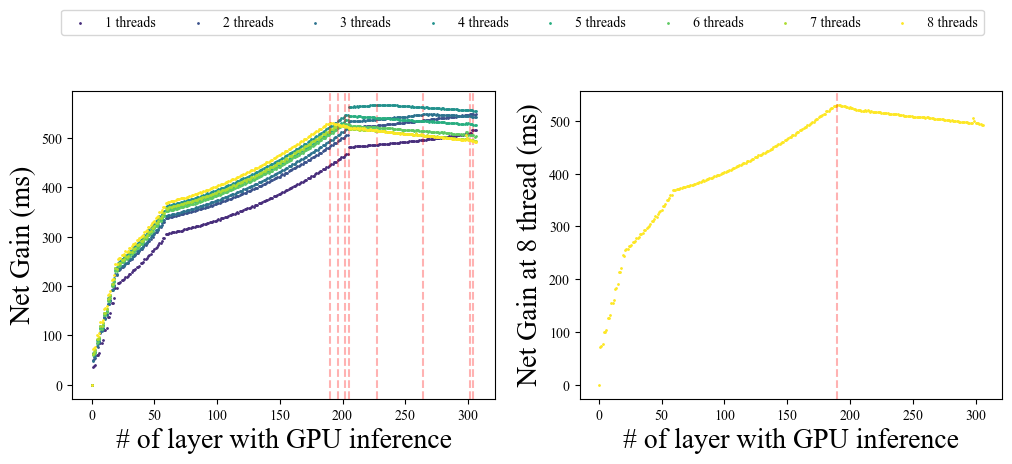

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for num_thread in range(1, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        #ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax1.scatter(data_df.index, data_df[('accel_gain', num_thread)] - data_df[('block_loss', num_thread)], color=color, label=f"{num_thread} threads", zorder = num_thread, s=1)
        ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)
ax2.scatter(data_df.index, data_df[('accel_gain', 8)] - data_df[('block_loss', 8)], color=color, zorder = num_thread, s=1)
ax2.axvline(x=max_values[8 - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)


ax1.set_ylabel("Net Gain (ms)", size=20)
ax1.set_xlabel('# of layer with GPU inference', size=20)
ax2.set_ylabel("Net Gain at 8 thread (ms)", size=20)
ax2.set_xlabel('# of layer with GPU inference', size=20)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8)

plt.show();


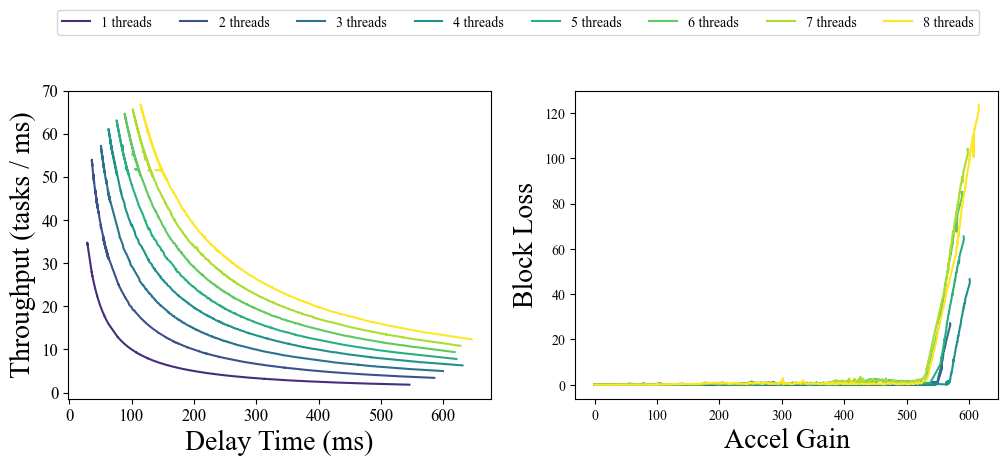

In [93]:
# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(1, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        #ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax1.plot(data_df[('execution_time', num_thread)], data_df[('throughput', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax2.plot(data_df[('accel_gain', num_thread)], data_df[('block_loss', num_thread)], color=color, zorder = num_thread)

        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)


# ax1.set_xlabel('# of layer with GPU inference', size=20)
# ax1.set_ylabel("Frame Rate (fps)", size=20)
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)

ax1.set_ylabel("Throughput (tasks / ms)", size=20)
ax2.set_xlabel("Accel Gain", size=20)
ax2.set_ylabel("Block Loss", size = 20)
ax1.set_xlabel('Delay Time (ms)', size=20)
# ax2.set_ylabel('Minimum # of thread', size=20)

ax1.tick_params(axis='both', labelsize=12)
# ax2.tick_params(axis='both', labelsize=12)
# ax3.tick_params(axis='both', labelsize=12)
#ax1.legend(loc='lower center', bbox_to_anchor=(-0.3, 0.1), fontsize=6)
#ax3.legend(loc='upper left', fontsize=3)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8)
#plt.tight_layout()
plt.show()


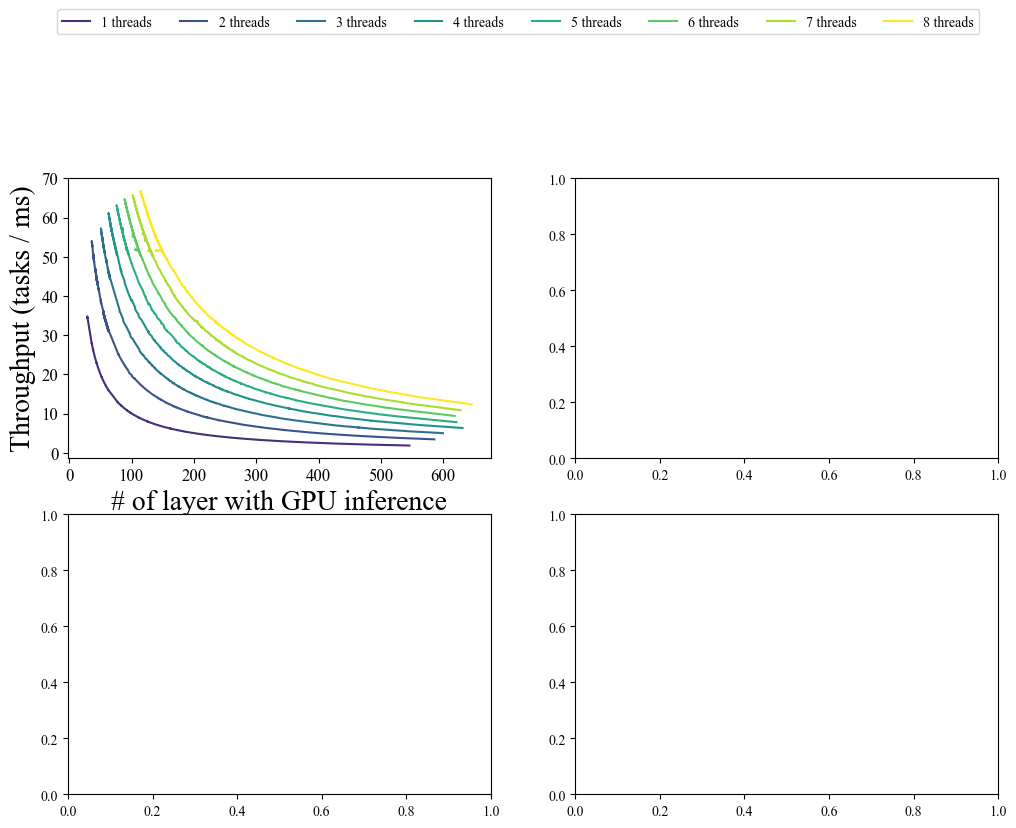

In [94]:
# Set up the plot
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, num_total_cores))  # max_total_cores개의 색상을 viridis 컬러맵에서 선택
# 각 스레드에 대한 데이터 플롯
for num_thread in range(1, num_total_cores):
    color = colors[num_thread % len(colors)]
    color_fill = colors_fill[num_thread]
    if num_thread in data_df.columns.levels[1]:
        #ax1.plot(data_df.index, data_df[('frame_rate', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        ax1.plot(data_df[('execution_time', num_thread)], data_df[('throughput', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        # ax2.scatter(data_df.index, data_df[('execution_time', num_thread)], color=color, zorder = num_thread, s=1)
        # ax3.scatter(data_df.index, data_df[('accel_gain', num_thread)], color=color, zorder = num_thread, s=1)
        # ax4.scatter(data_df.index, data_df[('block_loss', num_thread)], color=color, zorder = num_thread, s=1)
        # ax1.axvline(x=max_values[num_thread - 1]['glayer'], color='red', zorder = num_thread, linestyle='--', alpha=0.3)


        # if (num_thread == 1) or (num_thread == 2) or (num_thread == num_total_cores):
        #     ax2.plot(data_df.index, data_df[('num_thread_data', num_thread)], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index, data_df[('num_thread_data', num_thread)], color=color_fill, zorder=num_thread)
        # else:
        #     exceed_num = cross_points[num_thread - 3]['glayer']
        #     ax2.plot(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], label=f"{num_thread} threads", color=color, zorder = num_thread)
        #     ax2.fill_between(data_df.index[:exceed_num], data_df[('num_thread_data', num_thread)][:exceed_num], color=color_fill, zorder=num_thread)


# ax1.set_xlabel('# of layer with GPU inference', size=20)
# ax1.set_ylabel("Frame Rate (fps)", size=20)
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)

ax1.set_ylabel("Throughput (tasks / ms)", size=20)
ax1.set_xlabel('# of layer with GPU inference', size=20)
# ax2.set_ylabel('Minimum # of thread', size=20)

ax1.tick_params(axis='both', labelsize=12)
# ax2.tick_params(axis='both', labelsize=12)
# ax3.tick_params(axis='both', labelsize=12)
#ax1.legend(loc='lower center', bbox_to_anchor=(-0.3, 0.1), fontsize=6)
#ax3.legend(loc='upper left', fontsize=3)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8)
#plt.tight_layout()
plt.show()
